<a href="https://colab.research.google.com/github/underthegreen/qiskit-fall-fest-pnc-project-qrng/blob/main/qiskit_fall_fest_pnc_project_qrng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
#Installing required packages

!pip install qiskit
!pip install qiskit_aer
!pip install qiskit_ibm_runtime
!pip install matplotlib
!pip install qiskit-transpiler-service
!pip install pylatexenc

In [12]:
#Let's us import the required library/modules.

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, errors
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("ggplot")   # Make visuals nicer

In [13]:
#Creating qrng circuit

def binary_to_decimal(bits: str):
    return int(bits, 2)


def create_qrng_circuit(n_qubits, measure=True, draw=True):
    qc = QuantumCircuit(n_qubits, n_qubits if measure else 0)

    for i in range(n_qubits):
        qc.h(i)

    if measure:
        qc.measure(range(n_qubits), range(n_qubits))

    if draw:
        display(qc.draw("mpl"))
    return qc

In [14]:
# 1. QRNG — Statevector


def qrng_statevector(n_qubits, show_circuit=True):
    print("\n\n==============================")
    print("  1. Statevector QRNG output ")
    print("==============================\n")

    if show_circuit:
        print("Circuit:")
        create_qrng_circuit(n_qubits, measure=False, draw=True)

    qc = QuantumCircuit(n_qubits)
    for i in range(n_qubits):
        qc.h(i)

    sv = Statevector.from_instruction(qc)
    sample = sv.sample_counts(1)
    key = list(sample.keys())[0]

    print("Random bitstring:", key)
    print("Decimal value   :", binary_to_decimal(key))

    return binary_to_decimal(key)

In [15]:
# 2. QRNG — QASM Simulator

def qrng_qasm(n_qubits, show_circuit=True):
    print("\n\n============================")
    print("  2. QASMM Simulator Output ")
    print("============================\n")

    if show_circuit:
        print("Circuit:")
        qc = create_qrng_circuit(n_qubits, measure=True, draw=True)
    else:
        qc = create_qrng_circuit(n_qubits, measure=True, draw=False)

    simulator = AerSimulator()
    qc = transpile(qc, simulator)

    result = simulator.run(qc, shots=1).result()
    counts = result.get_counts()

    key = list(counts.keys())[0]

    print("Random bitstring:", key)
    print("Decimal value   :", binary_to_decimal(key))

    return binary_to_decimal(key)

In [16]:
# 3. QRNG — QASM With Noise

def qrng_noisy(n_qubits, show_circuit=True):
    print("\n\n============================")
    print("  3. Noisy QRNG Output ")
    print("============================\n")

    if show_circuit:
        print("Circuit:")
        qc = create_qrng_circuit(n_qubits, measure=True, draw=True)
    else:
        qc = create_qrng_circuit(n_qubits, measure=True, draw=False)

    simulator = AerSimulator()

    # Add depolarizing noise
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(
        errors.depolarizing_error(0.02, 1),
        ["h"]
    )

    qc = transpile(qc, simulator)

    result = simulator.run(qc, noise_model=noise_model, shots=1).result()
    counts = result.get_counts()

    key = list(counts.keys())[0]

    print("Random bitstring:", key)
    print("Decimal value   :", binary_to_decimal(key))

    return binary_to_decimal(key)


In [17]:
# 4. QRNG — Random Number in a Range


def qrng_range(max_value):
    print("\n\n======================================")
    print("  4. QRNG with range (0 to", max_value, ")")
    print("======================================\n")

    n_qubits = int(np.ceil(np.log2(max_value + 1)))

    while True:
        num = qrng_statevector(n_qubits, show_circuit=False)
        if num <= max_value:
            print("Random number (0–{}): {}".format(max_value, num))
            return num

In [18]:
# 5. QRNG Distribution Visualization

def visualize_distribution(n_qubits, shots=2048):
    print("\n\n======================================")
    print("  5. QRNG Distribution Histogram ")
    print("======================================\n")

    qc = create_qrng_circuit(n_qubits, measure=True, draw=True)

    simulator = AerSimulator()
    qc = transpile(qc, simulator)

    result = simulator.run(qc, shots=shots).result()
    counts = result.get_counts()

    # Plot histogram
    plt.figure(figsize=(10, 4))
    plt.bar(counts.keys(), counts.values())
    plt.xticks(rotation=70)
    plt.title("QRNG Distribution ({} shots)".format(shots))
    plt.xlabel("Measured State")
    plt.ylabel("Frequency")
    plt.show()

    # Calculate entropy
    total = sum(counts.values())
    entropy = 0
    for c in counts.values():
        p = c / total
        entropy -= p * np.log2(p)

    print("Entropy:", entropy)
    return counts

In [19]:
#6. Statistics Module

def analyze_qrng_statistics(data, plot=True):
    data = np.array(data)

    mean_val = np.mean(data)
    median_val = np.median(data)
    variance_val = np.var(data)
    std_population = np.std(data)
    std_sample = np.std(data, ddof=1)
    range_val = np.max(data) - np.min(data)

    # mode
    counts = Counter(data)
    max_freq = max(counts.values())
    mode_vals = [k for k, v in counts.items() if v == max_freq]
    if len(mode_vals) == len(data):
        mode_vals = "None"

    print("\n==================== 6. QRNG Statistical Analysis ====================")
    print("Total Samples        :", len(data))
    print("Mean                 :", mean_val)
    print("Median               :", median_val)
    print("Mode(s)              :", mode_vals)
    print("Range                :", range_val)
    print("Variance             :", variance_val)
    print("Std Dev (Population) :", std_population)
    print("Std Dev (Sample)     :", std_sample)
    print("======================================================================\n")

    # visualization
    if plot:
        plt.figure(figsize=(10, 5))
        plt.hist(data, bins=20, alpha=0.7)

        plt.axvline(mean_val, linestyle='--', linewidth=2,
                    label=f"Mean = {mean_val:.2f}")

        plt.axvspan(mean_val - std_population,
                    mean_val + std_population,
                    color="gray", alpha=0.2,
                    label="±1 Std Dev")

        plt.title("QRNG Output Histogram with Mean & Std Dev")
        plt.xlabel("Values")
        plt.ylabel("Frequency")
        plt.legend()
        plt.grid(True)
        plt.show()


Enter number of qubits: 5


  1. Statevector QRNG output 

Circuit:


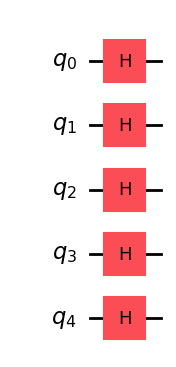

Random bitstring: 01100
Decimal value   : 12


  2. QASMM Simulator Output 

Circuit:


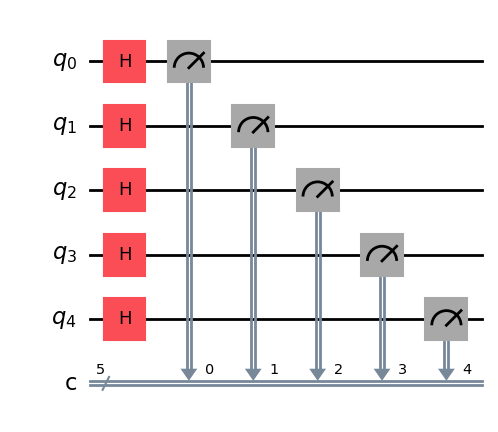

Random bitstring: 11000
Decimal value   : 24


  3. Noisy QRNG Output 

Circuit:


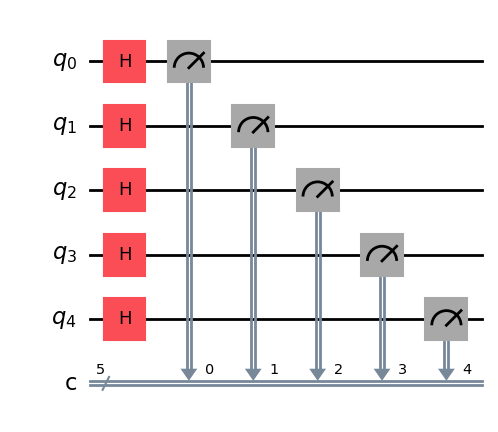

Random bitstring: 01100
Decimal value   : 12


  4. QRNG with range (0 to 30 )



  1. Statevector QRNG output 

Random bitstring: 01111
Decimal value   : 15
Random number (0–30): 15


  4. QRNG with range (0 to 30 )



  1. Statevector QRNG output 

Random bitstring: 01001
Decimal value   : 9
Random number (0–30): 9


  4. QRNG with range (0 to 30 )



  1. Statevector QRNG output 

Random bitstring: 01001
Decimal value   : 9
Random number (0–30): 9


  4. QRNG with range (0 to 30 )



  1. Statevector QRNG output 

Random bitstring: 01101
Decimal value   : 13
Random number (0–30): 13


  4. QRNG with range (0 to 30 )



  1. Statevector QRNG output 

Random bitstring: 01110
Decimal value   : 14
Random number (0–30): 14


  4. QRNG with range (0 to 30 )



  1. Statevector QRNG output 

Random bitstring: 11010
Decimal value   : 26
Random number (0–30): 26


  4. QRNG with range (0 to 30 )



  1. Statevector QRNG output 

Random bitstring: 10000
Decimal value   : 16
Random number (0–3

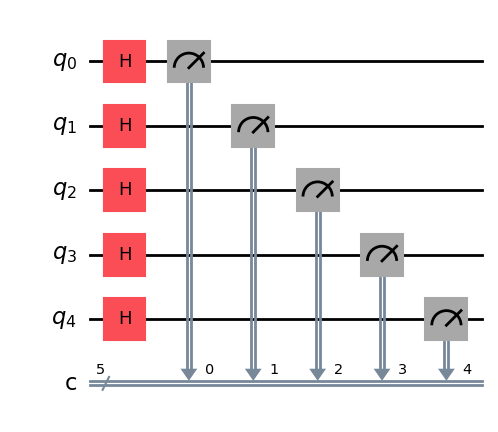

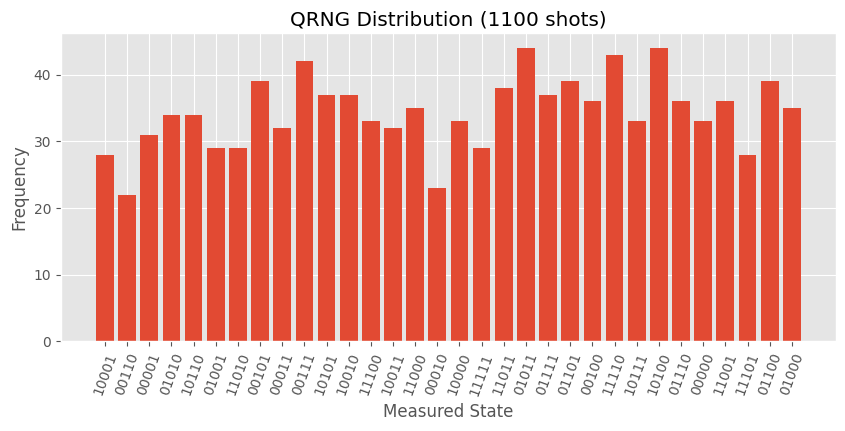

Entropy: 4.982293022878896

==================== 6. QRNG Statistical Analysis ====================
Total Samples        : 100
Mean                 : 15.18
Median               : 14.5
Mode(s)              : [np.int64(14)]
Range                : 30
Variance             : 71.18759999999999
Std Dev (Population) : 8.43727444142953
Std Dev (Sample)     : 8.479779871356724



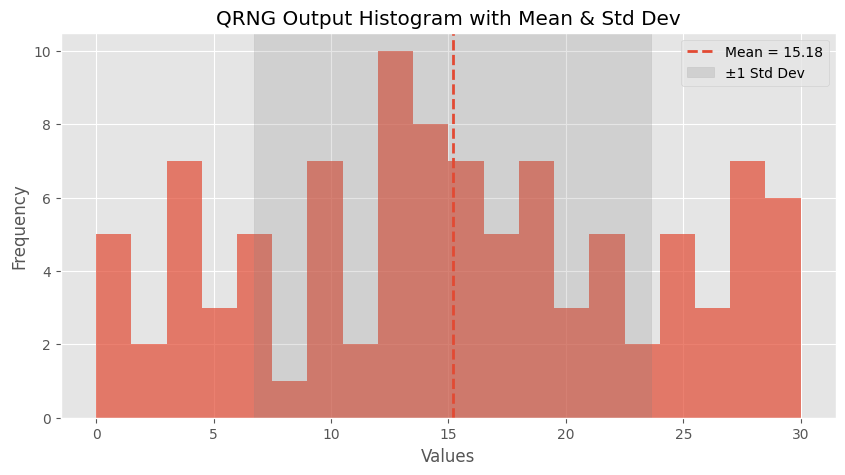

In [20]:
# Main Program for execution


from collections import Counter

n = int(input("Enter number of qubits: "))

# Run multiple separate outputs
qrng_statevector(n)
qrng_qasm(n)
qrng_noisy(n)

samples = []
for _ in range(100):
    samples.append(qrng_range(30))

visualize_distribution(n, shots=1100)
analyze_qrng_statistics(samples)
